In [32]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn import linear_model
from sklearn import model_selection
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gdown
import gc
from statsmodels.tsa import seasonal
from statsmodels.tsa.arima import model
from arch import univariate
import pmdarima as pm
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from sklearn import metrics
import warnings

# игнорируем предупреждения
warnings.filterwarnings('ignore')

In [2]:
# КОНСТАНТЫ
SRC_SUBFOLDER = './.'
# формируем относительный системный путь для импорта файлов с функциями
# если SRC_SUBFOLDER = './.' + './', получим относительный путь './../'
sys.path.append(os.path.relpath(SRC_SUBFOLDER + './'))

# <center> Модуль MATH&ML-13: временные ряды.<br>

# <center> Прогнозирование ВВП Ганы 

<center>
<img src=https://upload.wikimedia.org/wikipedia/commons/1/19/Flag_of_Ghana.svg width='100'> 
</center>

---

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили [показатели ВВП](https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ghana_gdp.zip) Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

---

## 1. Статистические модели прогнозирования

### **Задачи:**

1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

    Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

2. Постройте модель скользящего среднего, проанализируйте результат. Для построения *MA* используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

    Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели *ARMA / ARIMA*.

    > **Примечание.** Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром $d$ для модели *ARIMA*.

    Параметры $p$ и $q$ выберите по коррелограммам *ACF* и *PACF*.

    > **Примечание.** Помните, что параметры $p$ и $q$ для *ARMA / ARIMA* определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

    Постройте модель *ARMA / ARIMA* для прогнозирования поведения временного ряда.

    Также постройте несколько моделей с параметрами, ближайшими к найденным $p$ и $q$, и сравните коэффициент *AIC* (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

6. Сделайте выводы по полученным результатам.

---

### 1.1 Подготовка данных, предварительные выводы

In [13]:
DATA_SUBFOLDER = ''
url_data = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ghana_gdp.zip'
if os.path.isfile(DATA_SUBFOLDER + './data/ghana_gdp.csv') == False:
    # загружаем файл, выводим сообщения только при ошибке, перезаписываем при наличии в ./
    gdown.download(url=url_data, output='data.zip', quiet=True, fuzzy=True)
    # извлекаем загруженный архив в подкаталог для данных
    os.system('fast_unzip data.zip -d' + DATA_SUBFOLDER + './data/')
    # удаляем загруженный архив
    os.system('rm data.zip')

# считываем данные, задаём индексы и тип данных в них
gdp = pd.read_csv(DATA_SUBFOLDER + './data/ghana_gdp.csv', index_col=['year'], parse_dates=['year'])

# снимаем лишние предупреждения у моделей временных рядов
gdp.index = pd.DatetimeIndex(gdp.index.values, freq=gdp.index.inferred_freq)

# выводим результат
gdp.head()

,GDP (current US$)
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


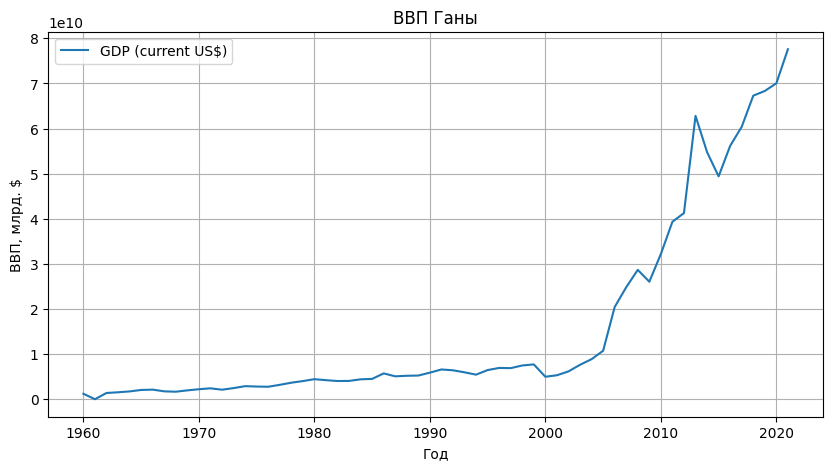

In [14]:
# визуализируем ВВП Ганы по годам
_, ax_line = plt.subplots(figsize=(10, 5))
ax_line = sns.lineplot(data=gdp, ax=ax_line)
ax_line.set(
    title='ВВП Ганы', 
    xlabel='Год', 
    ylabel='ВВП, ' + 'млрд. \$'
)
ax_line.grid();

На графике выше ↑ видно, что тренд возрастающий на всем протяжении, приблизительно, с 2000 года значительный рост.

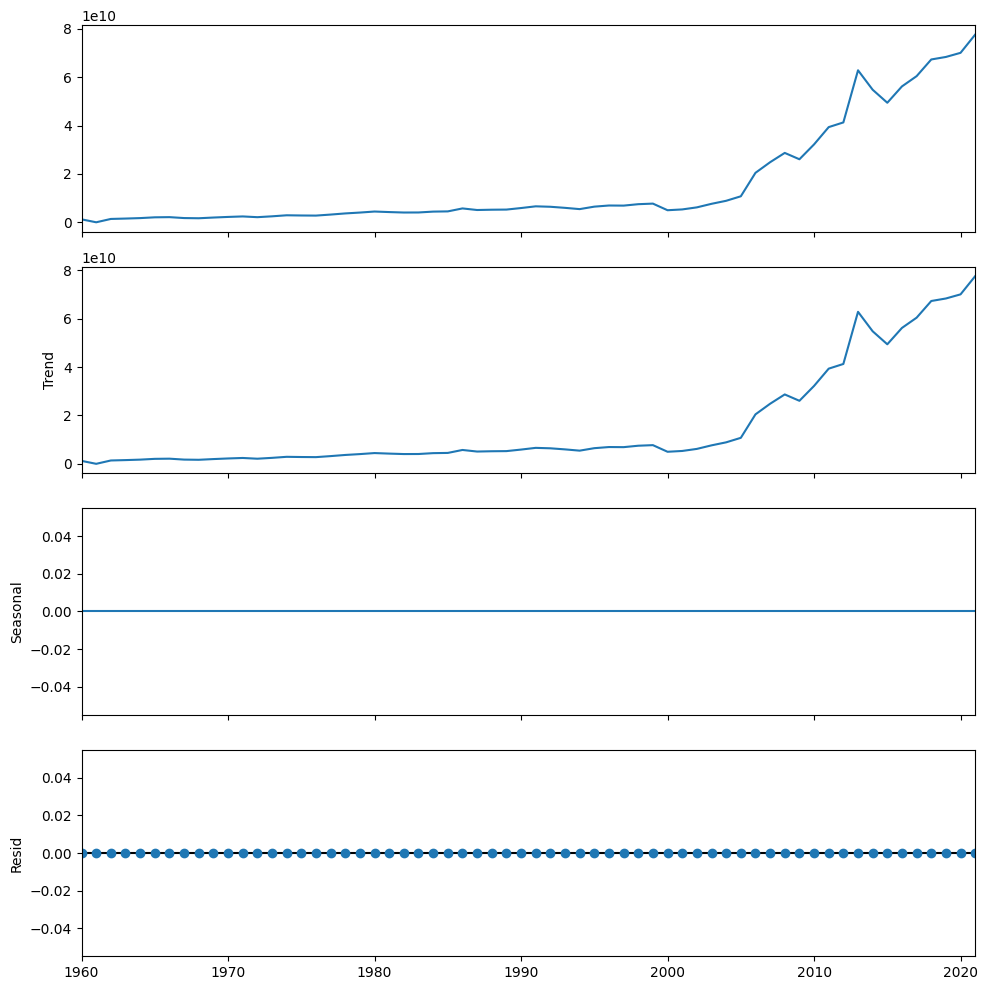

In [15]:
plt.rcParams['figure.figsize'] = 10, 10

# производим декомпозицию временного ряда
decomposition = seasonal.seasonal_decompose(gdp)
decomposition.plot();

Из графиков выше ↑ видно и можно сказать, что есть только восходящий (нарастающий) тренд.

In [16]:
# разбиение выборки
train_df, test_df = gdp[:-3], gdp[-3:]
# выводим результат
print(f'Размерность тренировочной выборки: {train_df.shape}')
print(f'Размерность тестовой выборки: {test_df.shape}')
del url_data, ax_line, decomposition
gc.collect();

Размерность тренировочной выборки: (59, 1)
Размерность тестовой выборки: (3, 1)


### **Выводы:**

Предварительная оценка, при анализе исходного ряда наблюдается:

* тренд;
* отсутствие сезонности;
* отсутствие шума, остатки сосредоточены около 0.

---

### 1.2. Модель SMA (простое скользящее среднее)

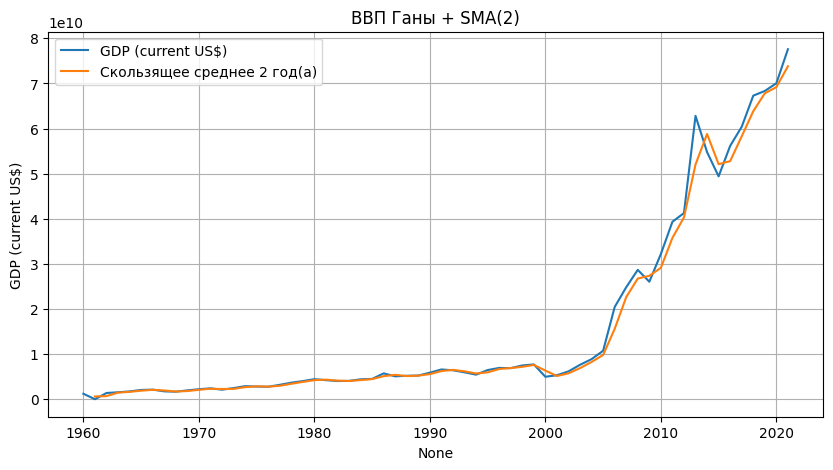

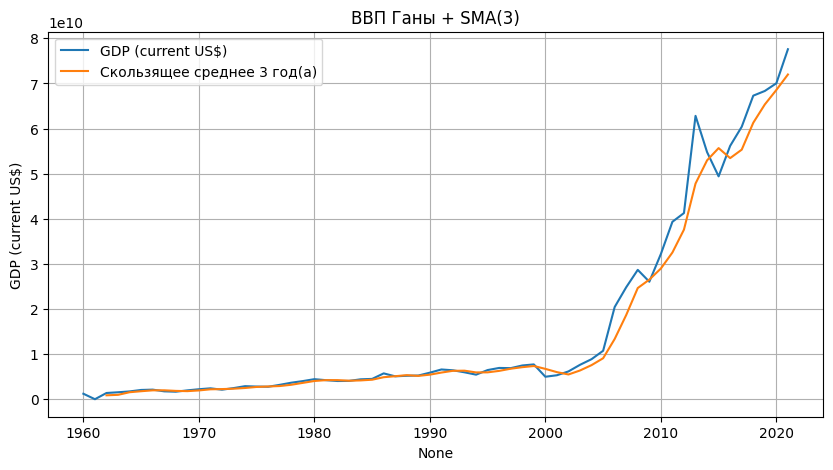

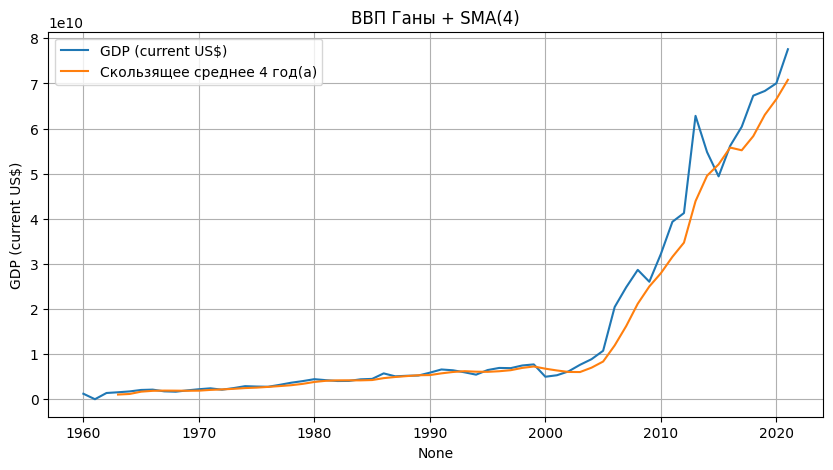

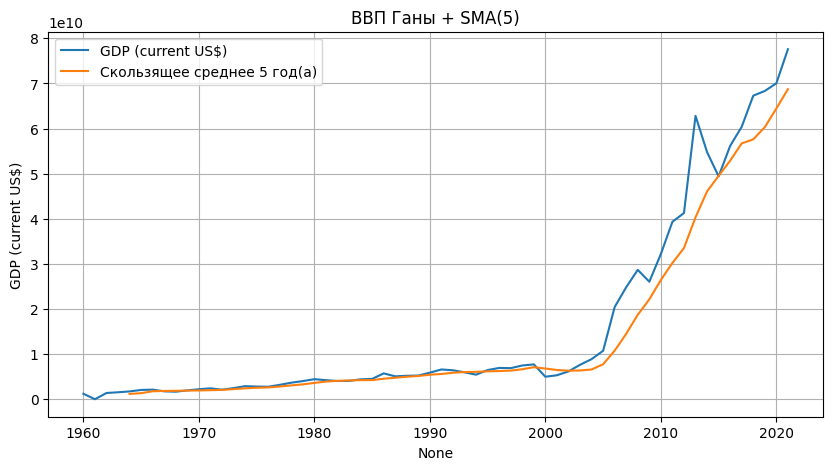

In [17]:
# строим SMA с окнами в диапазоне от 2 до 5, включительно
for i in range(2, 6):
    # задаём полотно
    fig, ax_line = plt.subplots(figsize=(10, 5))
    
    # строим график основных данных
    ax_line = sns.lineplot(x=gdp.index, y=gdp[gdp.columns[0]], label=gdp.columns[0])

    # строим график SMA
    ma = gdp.rolling(i).mean()
    ax_line = sns.lineplot(x=ma.index, y=ma[gdp.columns[0]], label='Скользящее среднее '  + str(i) + ' год(а)')
    
    # формируем заголовок и сетку
    ax_line.grid()
    _ = plt.title('ВВП Ганы + SMA(' + str(i) + ')')

Скользящее среднее помогает избавить временной ряд от выбросов и лишнего шума, это упрощает визуальный анализ, но вместе с тем, с увеличением "окна", оборотная сторона медали - приходится платить потерей данных, причем, существенно. Модель SМА с окном в 5 лет очень сильно сгладила график, потеряна часть данных - скачок в период 2008-2009, особенно в 2013-2015 гг., SМА с окном в 2 года сгладила данные более аккуратно, сохранив пики.

In [18]:
del i, fig, ax_line, ma
gc.collect();

### **Выводы:**

* С 1960 по 2002-2003 наблюдается очень медленный прирост ВВП ("ползучий" график), темп роста низкий;

* Резкий восходящий тренд прослеживается с 2004-2005 года, темп роста  высокий (кривая резко идет вверх);

* Данные тренда SMA подтверждены на декомпозиции временного ряда ранее.

---

### 1.3. Стационарность ряда, выбор модели, подбор гиперпараметров с помощью `pmdarima`

Оценим стационарность ряда с помощью функции `get_adfuller_test` (тест Дики-Фуллера):

In [20]:
def get_adfuller_test(
        df_:pd.DataFrame, 
        crit_val_:int=1
    ) -> None:
    """ Функция, реализующая тест Дики-Фуллера.

    Args:
        df_ (pd.DataFrame): 
            датафрейм для оценки

        crit_val_ (int, optional): 
            пороговое значения из словаря критических значений, значения от 1 до 3. Defaults to 1.
    """

    if  (crit_val_< 1) or (crit_val_ > 3):
        print('Пороговые значения могут быть только от 1 до 3, включительно')
        return None
    
    # выполянем тест
    result = stattools.adfuller(df_)

    # выводим результат
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

    # выводим заключение
    if result[0] > result[4][list(result[4].keys())[crit_val_ - 1]]: 
        print (f"При пороге '{list(result[4].keys())[crit_val_ - 1]}' есть единичные корни, ряд НЕ стационарен")
    else:
        print (f"При пороге '{list(result[4].keys())[crit_val_ - 1]}' единичных корней нет, ряд СТАЦИОНАРЕН")
        
# проверяем ряд на стационарность
get_adfuller_test(train_df, 2)

ADF Statistic: 0.6529066974885349
p-value: 0.9888496277665572
Critical Values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
При пороге '5%' есть единичные корни, ряд НЕ стационарен


In [21]:
# проверяем ряд на стационарность, интегрированный ряд 1-го порядка
get_adfuller_test(train_df.diff().dropna(), 2)

ADF Statistic: -1.6702483038320777
p-value: 0.446502932971389
Critical Values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
При пороге '5%' есть единичные корни, ряд НЕ стационарен


In [22]:
# проверяем ряд на стационарность, интегрированный ряд 2-го порядка
get_adfuller_test(train_df.diff(2).dropna(), 2)

ADF Statistic: -3.5836708658260297
p-value: 0.006080989753876957
Critical Values: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
При пороге '5%' единичных корней нет, ряд СТАЦИОНАРЕН


Интегрированный ряд 2-го порядка ряд стал стационарным, принимаем $d = 2$, т.к. ряд нестационарный, отсутствует сезонность и не требуется учитывать экзогенные переменные, то можно применить модель *ARIMA*.

Посмотрим на коррелограммы:

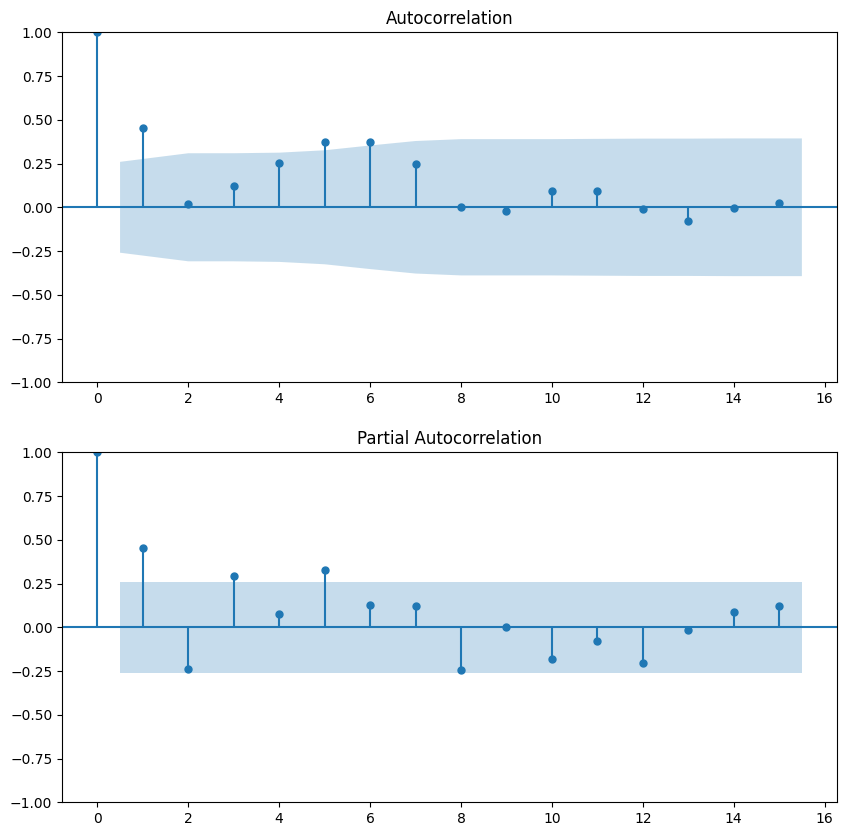

In [24]:
def get_correlograms(
        y_train_:pd.DataFrame, lags_:int=15, 
        figsize_:tuple=(10, 10)
    ) -> None:
    """ Функция, реализующая построение коррелограмм:
        - автокорреляция временного ряда;
        - автокорреляция частичных остатков временного ряда.

    Args:
        y_train_ (pd.DataFrame): вектор тренировочныъ значений

        lags_ (int, optional): число лагов (меток) на оси абсцисс. Defaults to 15.

        figsize_ (tuple, optional): размер общего полотна. Defaults to (10, 10).
    """

    # строим коррелограммы: 
    # автокорреляция (верхний), автокорреляция частичных остатков (нижний)
    _, axes = plt.subplots(2, 1, figsize=figsize_)
    tsaplots.plot_acf(y_train_, lags=lags_, ax=axes[0])
    tsaplots.plot_pacf(y_train_, lags=lags_, ax=axes[1])
    
get_correlograms(train_df.diff(2).dropna())

На основании графиков автокорреляции и частичной автокорреляции выбираем параметры для модели:

* $p = 1$,
* $q = 1$.

In [25]:
# создаём объект класса ARIMA, обучаем модель
ARIMA_1_2_1 = model.ARIMA(train_df, order=(1, 2, 1));
ARIMA_1_2_1_fit = ARIMA_1_2_1.fit()

# выводим результат
ARIMA_1_2_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Fri, 13 Sep 2024   AIC                           2684.416
Time:                        09:10:24   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

Попробуем подобрать оптимальные гиперпараметры для модели *ARIMA*:

* Параметр $p$: в диапазоне [1-10],
* Параметр $d$: в диапазоне [1-10],
* Параметр $q$: в диапазоне [1-10],
* Задаем отсутствие сезонности: **m = 0** и **seasonal=False**,
* Фиксируем **random_state** и **n_jobs**, чтобы результаты были без учёта стохастического влияния и с максимальной производительностью, делаем вывод расчётов **trace** и подавляем ошибки **error_action='ignore'**, **suppress_warnings=True**,
* Чтобы сократить вдвое время расчётов убираем расчёты с интерсептом: **with_intercept=False**.

In [26]:
RANDOM_SEED = 42
# ищем лучшие гиперпараметры
AUTO_ARIMA_1_2_1 = pm.auto_arima(
    train_df, 
    start_p=1, d=2, start_q=1,
    test='adf',
    max_p=10, max_d=10, 
    max_q=10, 
    m=0, seasonal=False, 
    trace=True,
    error_action='ignore', 
    suppress_warnings=True, 
    n_jobs=-1, 
    random_state=RANDOM_SEED, 
    with_intercept=False
)

# выводим результат
AUTO_ARIMA_1_2_1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.622, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2686.992, Time=0.04 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.648, Time=0.16 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.800, Time=0.11 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2688.234, Time=0.12 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.409, Time=0.21 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.657, Time=0.18 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 13 Sep 2024   AIC                           2680.765
Time:                        09:11:05   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [27]:
del ARIMA_1_2_1, ARIMA_1_2_1_fit
gc.collect();

### **Выводы:**

Наилучшие параметры получены для модели *ARIMA(1, 2, 3)*, т.к. коэффициент *AIC* для неё чуть меньше, чем *AIC* для *ARIMA(1, 2, 1)*: 2680.765 < 2684.416.

**Меньше, значит, лучше**, оптимальные гиперпараметры для *ARIMA* - *(1, 2, 3)*.

---

### 1.4. Построение оптимальной модели и предсказания для тестовой выборки

In [28]:
# создаём объект класса ARIMA, обучаем модель с лучшими гиперпараметрами
ARIMA_opt = model.ARIMA(
    train_df, 
    order=AUTO_ARIMA_1_2_1.get_params()['order']
)
ARIMA_opt_fit = ARIMA_opt.fit()

# выводим результат
ARIMA_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 13 Sep 2024   AIC                           2680.765
Time:                        09:11:51   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

Вычислим для оптимальной модели предсказание:

In [29]:
# создаём отдельный датафрейм с индексами первоначального 
pred_ARIMA_opt_fit = pd.DataFrame(index=gdp.index)

# вычисляем предсказание для тестовой выборки в новый признак 'model_preds'
pred_ARIMA_opt_fit['model_preds'] = ARIMA_opt_fit.predict(
    start=test_df.index[0], 
    end=test_df.index[-1]
)

# переносим истинные значения в датафрейм предсказания
pred_ARIMA_opt_fit[gdp.columns[0]] = gdp[gdp.columns[0]]

# формируем доверительный интервал в 95%
forecast = ARIMA_opt_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05)   # Confidence level of 95%

# добавляем доверительный интервал для 3 последних значений
pred_ARIMA_opt_fit.at[test_df.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_ARIMA_opt_fit.at[test_df.index, 'model_preds_upper'] = forecast_df['upper GDP (current US$)']
pred_ARIMA_opt_fit.tail()

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.789080e+10,6.833754e+10,5.941329e+10,7.636831e+10
2020-01-01,7.253326e+10,7.004320e+10,6.050774e+10,8.455877e+10
2021-01-01,7.517348e+10,7.759428e+10,6.155656e+10,8.879040e+10


In [30]:
del AUTO_ARIMA_1_2_1, forecast, forecast_df
gc.collect();

---

### 1.5. Построение графиков истинного и предсказанного поведения временного ряда

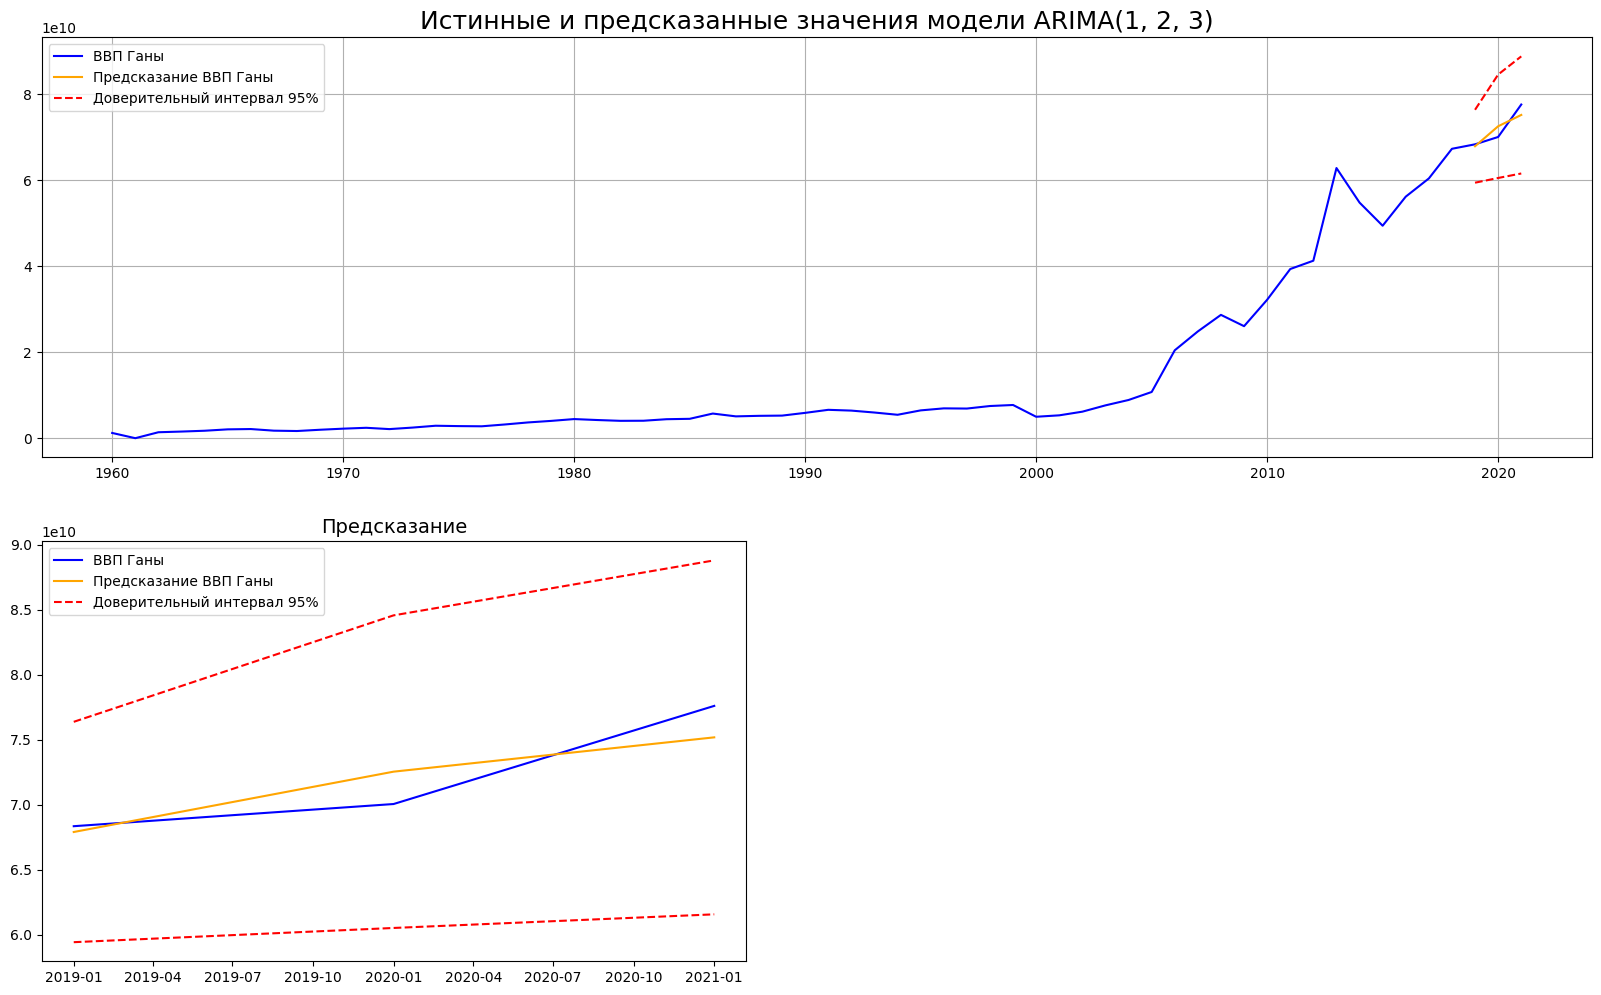

In [31]:
def get_plot_time_series_predicted(
        y_pred_:pd.DataFrame, y_test_:pd.DataFrame, 
        title_main:str, title_pred:str,
        color_main:str='blue', color_pred:str='orange', 
        color_pred_border:str='red', pred_border_style='--',
        grid_main:bool=True, grid_pred:bool=False, 
        figsize_:tuple=(20, 12)
    ) -> None:
    """ Функция, реализующая построеник графика предсказания на общем графике и с масштабированием

    Args:
        y_pred_ (pd.DataFrame): массив предсказанных значений с границами доверительными значений
        y_test_ (pd.DataFrame): вектор тестовых значений
        title_main (str): заголовок основного графика
        title_pred (str): заголовок масштабированного графика предсказания
        color_main (str, optional): цвет основного графика. Defaults to 'blue'.
        color_pred (str, optional): цвет графика предсказания. Defaults to 'orange'.
        color_pred_border (str, optional): цвет границ доверительных интервалов. Defaults to 'red'.
        pred_border_style (str, optional): стиль границ доверительных интервалов. Defaults to '--'.
        grid_main (bool, optional): сетка основного графика. Defaults to True.
        grid_pred (bool, optional): сетка графика предсказания. Defaults to False.
        figsize_ (tuple, optional): общиай размер полотна. Defaults to (20, 12).
    """

    def get_plot_pred_only():
        """ Функция, реализующая отрисовку только предсказания 
            с доверительными границами на общем графике и с масштабированием
        """
        plt.plot(
            y_pred_.loc[y_test_.index][y_pred_.columns[0]], 
            color=color_pred, 
            label='Предсказание ВВП Ганы'
        )
        plt.plot(
            y_pred_.loc[y_test_.index][y_pred_.columns[2]], 
            color=color_pred_border, 
            linestyle=pred_border_style, label='Доверительный интервал 95%'
        )
        plt.plot(
            y_pred_.loc[y_test_.index][y_pred_.columns[3]], 
            color=color_pred_border, 
            linestyle=pred_border_style
        )


    # размер общего полотна
    plt.figure(figsize=figsize_)

    # верхний график
    plt.subplot(2, 1, 1)
    plt.plot(
        y_pred_[y_pred_.columns[1]], 
        color=color_main, label='ВВП Ганы'
    )
    get_plot_pred_only()
    plt.title(title_main, size = 18)

    # если нужна сетка
    if grid_main: plt.grid()

    plt.legend()

    # нижний график
    plt.subplot(2, 2, 3)
    plt.plot(
        y_pred_.loc[y_test_.index][y_pred_.columns[1]], 
        color=color_main, label='ВВП Ганы'
    )
    get_plot_pred_only()
    plt.title(title_pred, size=14)

    # если нужна сетка
    if grid_pred: plt.grid()

    plt.legend()
get_plot_time_series_predicted(
    pred_ARIMA_opt_fit, test_df, 
    f"Истинные и предсказанные значения модели ARIMA{ARIMA_opt_fit.specification['order']}", 
    'Предсказание'
)

### **Выводы:**

Построенная модель *ARIMA(1, 2, 3)* уловила динамику и тренд временного ряда и довольно близко предсказала значения ВВП Ганы за 2019-2021 годы к истинным значениям, в 2019 году предсказание модели было наиболее близко к фактической величине.

---

### 1.6. Метрики, выводы

In [33]:
# точность вывода для вычислений
TOL = 5

def mase(
        y_true_:pd.DataFrame, y_pred_:pd.DataFrame, 
        y_train_:pd.DataFrame, season_period_:int=1
    ) -> float:
    """ Функция, реализующая вычисление метрики MASE - средняя абсолютная масштабированная ошибка 
        (mean absolute scaled error).
        Если значение MASE меньше 1, то новая модель работает лучше, 
        если значение MASE равно 1, то модели работают одинаково, 
        если значение MASE больше 1, то исходная модель работает лучше, чем новая модель.

    Args:
        y_true_ (pd.DataFrame): вектор тестовых значений
        y_pred_ (pd.DataFrame): вектор предсказанных значений
        y_train_ (pd.DataFrame): вектор тренировочных значений
        season_period_ (int, optional): количество периодов в полном сезонном цикле. Defaults to 1.

    Returns:
        float: значение метрики MASE
    """

    # формируем значения наивного прогноза
    y_pred_naive = y_train_[:-season_period_]
    # вычисляем метрику MAE наивного прогноза
    mae_naive = metrics.mean_absolute_error(y_train_[season_period_:], y_pred_naive)
    # вычисляем метрику MAE
    mae_pred = metrics.mean_absolute_error(y_true_, y_pred_)
    # метрика MASE
    return np.round(mae_pred / mae_naive, 3)

def get_metrics(
        y_true_:pd.DataFrame, y_pred_:pd.DataFrame, 
        y_train_:pd.DataFrame, season_period_:int=1
    ) -> None:
    """ Функция, реализующая вычисление метрик MAPE, MSE, RMSE, R2, MASE.

    Args:
        y_true_ (pd.DataFrame): вектор тестовых значений
        y_pred_ (pd.DataFrame): вектор предсказанных значений
        y_train_ (pd.DataFrame): вектор тренировочных значений
        season_period_ (int, optional): количество периодов в полном сезонном цикле. Defaults to 1.
    """
    
    # вычисляем метрики
    mape_score = metrics.mean_absolute_percentage_error(y_true_, y_pred_) * 100
    mse_score = metrics.mean_squared_error(y_true_, y_pred_) * 100
    rmse_score = metrics.mean_squared_error(y_true_, y_pred_, squared=False)
    r2_score = metrics.r2_score(y_true_, y_pred_)
    mase_score = mase(y_true_, y_pred_, y_train_, season_period_)

    # выводим метрики
    print(f'MAPE: {mape_score:.{int(TOL/2)}f} %')
    print(f'MSE: {mse_score:.{TOL}e} $^2')
    print(f'RMSE: {rmse_score:.{TOL}e} $')
    print(f'R2: {r2_score:.{TOL - 2}f}')
    print(f'MASE: {mase_score:.{TOL - 2}f}')
    
# метрики SMA(2)
get_metrics(test_df, gdp['GDP (current US$)'].rolling(2).mean().iloc[-3:], train_df)

MAPE: 2.28 %
MSE: 5.08384e+20 $^2
RMSE: 2.25474e+09 $
R2: 0.686
MASE: 0.886


In [34]:
# метрики оптимизированной ARIMA(1, 2, 3)
get_metrics(test_df, pred_ARIMA_opt_fit['model_preds'][-3:], train_df)

MAPE: 2.44 %
MSE: 4.08675e+20 $^2
RMSE: 2.02157e+09 $
R2: 0.747
MASE: 0.922


### **Выводы:**

Метрики для *SMA(2)* и оптимизированной *ARIMA (1, 2, 3)* показывают, что несмотря на лучшую метрику MAE, модель *SMA* показывает результат, в целом, хуже, чем оптимизированная модель *ARIMA*.

В таблице сведены метрики по каждой модели:

<center>

| Метрика | <div style="width:200px">SMA(2)</div> | <div style="width:200px">ARIMA(1, 2, 3)</div> |
| :---: | :---: | :---: |
| $AIC$ | - | 2680.513 |
| $MAPE, \%$ | <font color='LightSeaGreen'>**2.28**</font> | <font color='Tomato'>**2.44**</font> |
| $MSE, \$^2$ | 5.08384e+20 | <font color='LightSeaGreen'>**4.08675e+20**</font> |
| $RMSE, \$$ | 2.25474e+09 | <font color='LightSeaGreen'>**2.02157e+09**</font> |
| $R_2$ | 0.686 | <font color='LightSeaGreen'>**0.747**</font> |
| $MASE$ | 0.886 | <font color='LightSeaGreen'>**0.922**</font> |

</center>

<br>

---

## 2. Интерполяция и сэмлирование.<br> Построение модели на интерполированных данных

### **Задачи:**

1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода **[DataFrame.asfreq()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html)**, передав в него параметр частоты, например '*d*' — день, '*m*' — месяц. Все алиасы для параметров частоты доступны **[по ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)**.

2. Проверьте данные на наличие пропущенных значений с помощью:

    ```py
    Series.isna().sum()
    ```

3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на *NaN*. Воспользуйтесь кодом ниже:

    ```py
    import numpy as np
    df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
    ```

4. Для заполнения пропусков выполните интерполяцию с использованием метода `.interpolate()`:

    ```py
    df['GDP (current US$)'].interpolate(method='linear')
    ```

5. Проверьте полученный ряд на стационарность, определите параметры модели *ARIMA / ARMA* и запустите модель.

6. Изменился ли *AIC* критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

---

### 2.1. Проверка на пропуски дат

Проверяем данные с помощью **DataFrame.asfreq()** (параметр *freq* указываем как начало каждого года, то есть '*YS*' или '*AS*', из документации):

In [35]:
# т.к. метод .asfreq() возвращает новый датафрейм, сохраняем его
gdp_mod = gdp.asfreq(freq='YS')
gdp_mod

,GDP (current US$)
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10


### **Выводы:**

Без изменений, пропусков дат нет.

---

### 2.2. Проверка на наличие пропущенных значений

In [36]:
gdp_mod.isna().sum()

GDP (current US$)    0
dtype: int64

### 2.3. Проверка на наличие пропущенных значений нулями, замена на *NaN*

Визуально сразу имеется единственное значение, т.к. иногда пропуски в данных могут быть заполнены нулями, проверим дополнительно наличие ещё подобных значений. Сделаем проверку на наличие нулевых значений и в случае нахождения, заменим их на *NaN*:

In [37]:
gdp_mod[gdp_mod[gdp_mod.columns[0]]==0]

,GDP (current US$)
1961-01-01,0.0


In [38]:
# заменяем нулевые значения
gdp_mod[gdp_mod.columns[0]] = gdp_mod[gdp_mod.columns[0]].apply(lambda x: np.nan if x==0 else x)
# выводим результат
gdp_mod[gdp_mod[gdp_mod.columns[0]].isna()==True]

,GDP (current US$)
1961-01-01,NaN


### 2.4. Интерполяция *NaN*-значений

После заполнения нулей значением '*NaN*' был выявлен один пропуск, заполним его:

In [39]:
# интерполируем значение
gdp_mod[gdp_mod.columns[0]].interpolate(method='linear', inplace=True)

# выводим результат
gdp_mod.isna().sum()

GDP (current US$)    0
dtype: int64

Выполним разбиение датасета с обновлённой выборкой:

In [40]:
# разбиение выборки
train_df, test_df = gdp_mod[:-3], gdp_mod[-3:]

# выводим результат
print(f'Размерность тренировочной выборки: {train_df.shape}')
print(f'Размерность тестовой выборки: {test_df.shape}')

Размерность тренировочной выборки: (59, 1)
Размерность тестовой выборки: (3, 1)


### 2.5. Стационарность ряда, выбор модели, подбор гиперпараметров с помощью `pmdarima`

Оценим стационарность ряда (тест Дики-Фуллера):

In [41]:
# проверяем ряд на стационарность
get_adfuller_test(train_df, 2)

ADF Statistic: 0.8030073326980129
p-value: 0.9916845572455877
Critical Values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
При пороге '5%' есть единичные корни, ряд НЕ стационарен


In [42]:
# проверяем ряд на стационарность, интегрированный ряд 1-го порядка
get_adfuller_test(train_df.diff().dropna(), 2)

ADF Statistic: -1.8255652246435998
p-value: 0.36784515276563423
Critical Values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
При пороге '5%' есть единичные корни, ряд НЕ стационарен


In [43]:
# проверяем ряд на стационарность, интегрированный ряд 2-го порядка
get_adfuller_test(train_df.diff(2).dropna(), 2)

ADF Statistic: -3.999803440949147
p-value: 0.0014115408436661371
Critical Values: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
При пороге '5%' единичных корней нет, ряд СТАЦИОНАРЕН


Интегрированный ряд 2-го порядка ряд стал стационарным, принимаем $d = 2$, т.к. ряд нестационарный, отсутствует сезонность и не требуется учитывать экзогенные переменные, то можно применить модель *ARIMA*.

Посмотрим на коррелограммы:

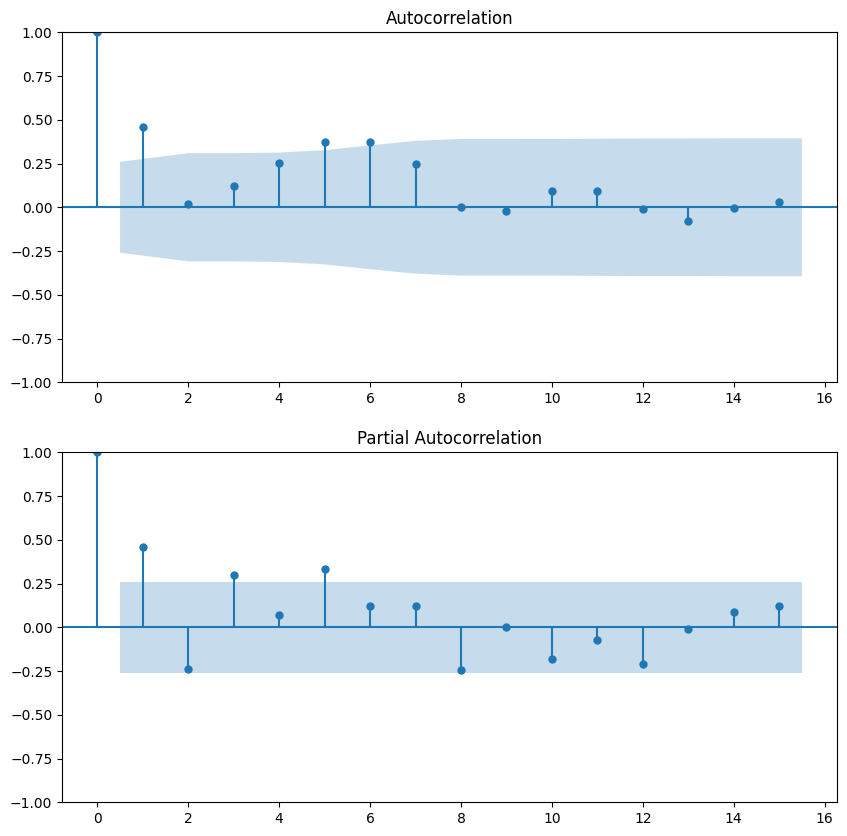

In [44]:
get_correlograms(train_df.diff(2).dropna())

На основании графиков автокорреляции и частичной автокорреляции выбираем параметры для модели:

* $p = 1$,
* $q = 1$.

In [45]:
# создаём объект класса ARIMA, обучаем модель на интерполированном признаке
ARIMA_1_2_1_mod = model.ARIMA(train_df, order=(1, 2, 1));
ARIMA_1_2_1_mod_fit = ARIMA_1_2_1_mod.fit()

# выводим результат
ARIMA_1_2_1_mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.188
Date:                Fri, 13 Sep 2024   AIC                           2684.377
Time:                        09:15:02   BIC                           2690.506
Sample:                    01-01-1960   HQIC                          2686.759
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1750      0.082     -2.127      0.033      -0.336      -0.014
ma.L1         -0.8690      0.046    -19.050      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22   9.21e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               277.83
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             480.68   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.5e+56. Standard errors may be unstable.
"""

Метрика *AIC* для *ARIMA(1, 2, 1) с интерполированными значениями* совсем <font color='LightSeaGreen'>**немного улучшилась**</font>, сказывается корректировка ряда ненулевым значением:

* было - 2684.416
* стало - <font color='LightSeaGreen'>**2684.377**</font>

Попробуем подобрать оптимальные гиперпараметры для модели ARIMA:

* Параметр $p$: в диапазоне [1-10],
* Параметр $d$: в диапазоне [1-10],
* Параметр $q$: в диапазоне [1-10],
* Задаем отсутствие сезонности: **m = 0** и **seasonal=False**,
* Фиксируем **random_state** и **n_jobs**, чтобы результаты были без учёта стохастического влияния и с максимальной производительностью, делаем вывод расчётов **trace** и подавляем ошибки **error_action='ignore'**, **suppress_warnings=True**,
* Чтобы сократить вдвое время расчётов убираем расчёты с интерсептом: **with_intercept=False**.

In [46]:
# ищем лучшие гиперпараметры для модели интерполированными значениями
AUTO_ARIMA_1_2_1_mod = pm.auto_arima(
    train_df, 
    start_p=1, d=2, start_q=1,
    test='adf',
    max_p=10, max_d=10, 
    max_q=10, 
    m=0, seasonal=False, 
    trace=True,
    error_action='ignore', 
    suppress_warnings=True, 
    n_jobs=-1, 
    random_state=RANDOM_SEED, 
    with_intercept=False
)

# выводим результат
AUTO_ARIMA_1_2_1_mod.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.547, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.09 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.04 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.12 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.617, Time=0.12 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2687.812, Time=0.10 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.040, Time=0.21 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=0.25 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 13 Sep 2024   AIC                           2680.513
Time:                        09:15:15   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [47]:
del ARIMA_1_2_1_mod, ARIMA_1_2_1_mod_fit
gc.collect();

Наилучшие параметры получены для оптимизированной модели *ARIMA(1, 2, 3) с интерполированными значениями*, т.к. коэффициент *AIC* для неё чуть меньше, чем *AIC* для *ARIMA(1, 2, 1) с интерполированными значениями*: 2680.513 < 2684.377.

**Меньше, значит, лучше**, оптимальные гиперпараметры для *ARIMA с интерполированными значениями* - *(1, 2, 3)*.

Построим оптимальную модель на интерполированном признаке:

In [48]:
# создаём объект класса ARIMA, обучаем модель с лучшими гиперпараметрами
ARIMA_opt_mod = model.ARIMA(
    train_df, 
    order=AUTO_ARIMA_1_2_1_mod.get_params()['order']
)
ARIMA_opt_mod_fit = ARIMA_opt_mod.fit()

# выводим результат
ARIMA_opt_mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 13 Sep 2024   AIC                           2680.513
Time:                        09:15:22   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

Вычислим для оптимальной модели предсказание:

In [49]:
# создаём отдельный датафрейм с индексами первоначального 
pred_ARIMA_opt_mod_fit = pd.DataFrame(index=gdp_mod.index)

# вычисляем предсказание для тестовой выборки в новый признак 'model_preds'
pred_ARIMA_opt_mod_fit['model_preds'] = ARIMA_opt_mod_fit.predict(
    start=test_df.index[0], 
    end=test_df.index[-1]
)

# переносим истинные значения в датафрейм предсказания
pred_ARIMA_opt_mod_fit[gdp_mod.columns[0]] = gdp_mod[gdp_mod.columns[0]]
# формируем доверительный интервал в 95%
forecast_mod = ARIMA_opt_mod_fit.get_forecast(len(test_df.index))
forecast_df_mod = forecast_mod.conf_int(alpha = 0.05)   # Confidence level of 95%
# добавляем доверительный интервал для 3 последних значений
pred_ARIMA_opt_mod_fit.at[test_df.index, 'model_preds_lower'] = forecast_df_mod['lower GDP (current US$)']
pred_ARIMA_opt_mod_fit.at[test_df.index, 'model_preds_upper'] = forecast_df_mod['upper GDP (current US$)']
pred_ARIMA_opt_mod_fit.tail()

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.781358e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10


In [50]:
del AUTO_ARIMA_1_2_1_mod, forecast_mod, forecast_df_mod
gc.collect();

Для полноты картины построим график предсказания и убедимся, что <font color='LightSeaGreen'>**отличий визуально нет**</font>, т.к. '*AIC*' не изменился, по сравнению с предыдущей оптимизированной моделью *ARIMA*:

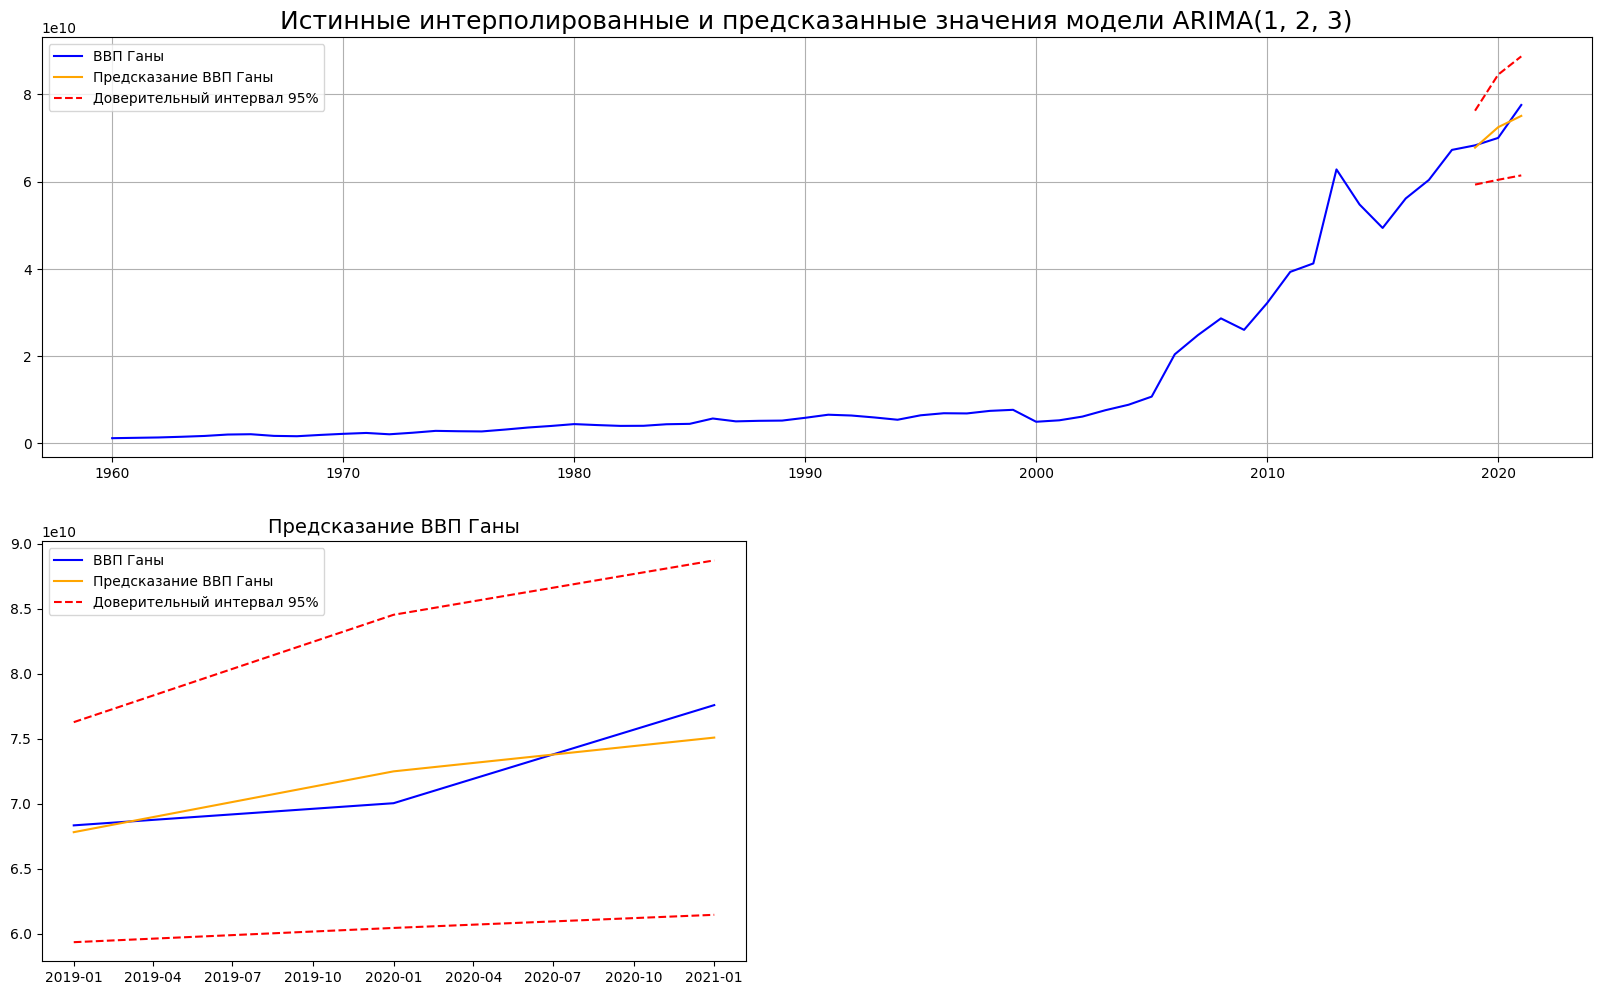

In [51]:
get_plot_time_series_predicted(
    pred_ARIMA_opt_mod_fit, test_df, 
    f"Истинные интерполированные и предсказанные значения модели ARIMA{ARIMA_opt_mod_fit.specification['order']}", 
    'Предсказание ВВП Ганы'
)

### **Выводы:**

Без изменений.

---

### 2.6. Метрики, выводы

In [52]:
# метрики оптимизированной ARIMA с интерполированными значениями
get_metrics(test_df, pred_ARIMA_opt_mod_fit['model_preds'][-3:], train_df)

MAPE: 2.50 %
MSE: 4.17896e+20 $^2
RMSE: 2.04425e+09 $
R2: 0.742
MASE: 0.963


### **Выводы:**

Метрики для оптимизированной *ARIMA с интерполированными значениями* показывают небольшую просадку по всем метрикам, кроме *MASE*. Просадку легко объяснить тем, что вместо 0 значения, теперь 9-значное значение, что не может не вызывать минимальную корректировку метрик. И тем, не менее, новая оптимизированная модель *ARIMA на интерполированном признаке* показывает метрику *MASE* лучше, чем модель оптимизированной *ARIMA на первоначальных признаках*.

А, значит, новая модель, на интерполированных признаках - **лучшая**, хоть, и *AIC* не изменился.

В таблице сведены метрики по каждой модели:

<center>

| Метрика | <div style="width:200px">ARIMA(1, 2, 3)<br>с интерполяцией</div> | <div style="width:200px">ARIMA(1, 2, 3)</div> |
| :---: | :---: | :---: |
| $AIC$ | 2680.513 | 2680.513 |
| $MAPE, \%$ | 2.50 | 2.44|
| $MSE, \$^2$ | 4.17896e+20 | 4.08675e+20 |
| $RMSE, \$$ | 2.04425e+09 | 2.02157e+09 |
| $R_2$ | 0.742 | 0.747 |
| $MASE$ | <font color='LightSeaGreen'>**0.963**</font> | 0.922 |

</center>

<br>

---

## 3. Гетероскедатичность

### **Задачи:**

1. Посчитайте волатильность для вашего временного ряда.

2. Используйте *GARCH*-модель для предсказания волатильности.

3. Используйте линейную регрессию для получения прогноза.

4. Визуализируйте полученное предсказание вместе с фактическим значением.

5. Сравните результаты и сделайте выводы.

6. Почему результат модели *GARCH* получился именно таким?

---

### 3.1. Волатильность

In [53]:
# вычисляем волатильность временного ряда
gdp_vol = pd.DataFrame(
    gdp_mod[gdp_mod.columns[0]].pct_change(1).mul(100).abs().dropna().rename('GDP_vol')
)

# выводим результат
gdp_vol.head()

,GDP_vol
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
1965-01-01,18.608414


Проверим ряд на **гетероскедастичность** т.е. на неоднородность наблюдений, выражающаяся в неодинаковой дисперсии. Для этого создадим вспомогательный признак '*GDP_vol_sqrd*', где будут находиться квадраты значений, отобразим их на графике:

In [54]:
# формируем вспомогательный признак
gdp_vol['GDP_vol_sqrd'] = gdp_vol['GDP_vol'].apply(lambda x: x**2)
# выводим результат
gdp_vol.head()

,GDP_vol,GDP_vol_sqrd
1961-01-01,6.789413,46.096130
1962-01-01,6.357759,40.421095
1963-01-01,11.448835,131.075819
1964-01-01,12.363636,152.859504
1965-01-01,18.608414,346.273081


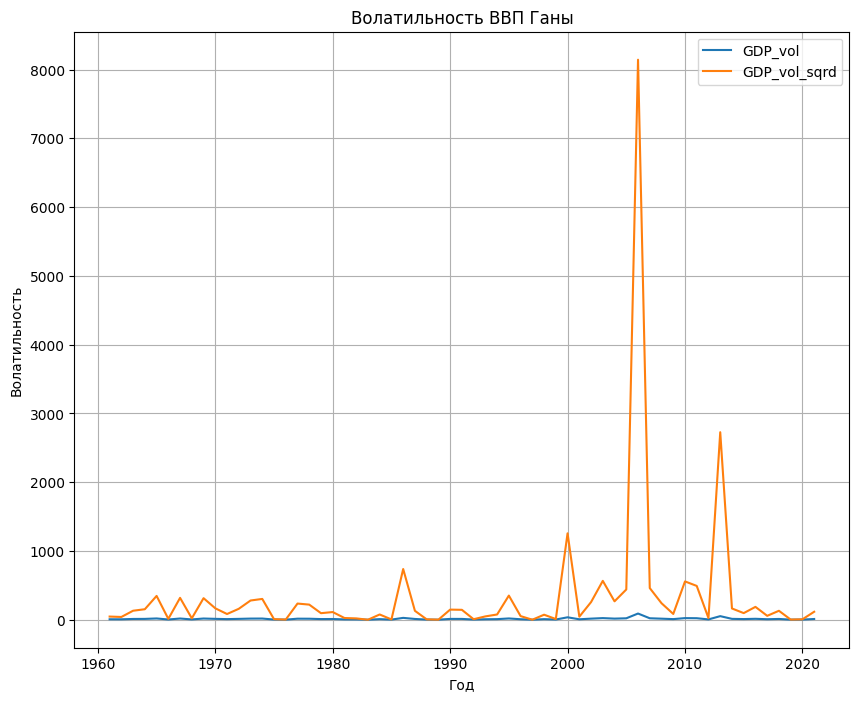

In [55]:
# задаём полотно
fig, ax_line = plt.subplots(figsize=(10, 8))

# строим графики
ax_line = sns.lineplot(
    x=gdp_vol.index, y=gdp_vol[gdp_vol.columns[0]], label=gdp_vol.columns[0])
ax_line = sns.lineplot(
    x=gdp_vol.index, y=gdp_vol[gdp_vol.columns[1]], label=gdp_vol.columns[1])

# формируем заголовок и сетку
ax_line.set(
    title='Волатильность ВВП Ганы', 
    xlabel='Год', 
    ylabel='Волатильность'
)

ax_line.grid();

In [56]:
# пиковые значения волатильности
print(f"{round(gdp_vol['GDP_vol'].loc['1986-01-01'])} %")
print(f"{round(gdp_vol['GDP_vol'].loc['2000-01-01'])} %")
print(f"{round(gdp_vol['GDP_vol'].loc['2003-01-01'])} %")
print(f"{round(gdp_vol['GDP_vol'].loc['2006-01-01'])} %")
print(f"{round(gdp_vol['GDP_vol'].loc['2010-01-01'])} %")
print(f"{round(gdp_vol['GDP_vol'].loc['2013-01-01'])} %")

27 %
35 %
24 %
90 %
24 %
52 %


In [57]:
# прибираемся немного
del fig, ax_line

# убираем вспомогательный признак
gdp_vol.drop(columns=['GDP_vol_sqrd'], inplace=True)

gc.collect();

### **Выводы:**

График волатильности на всём своём периоде наблюдения характеризуется стабильной волатильностью с выделением нескольких резких пиков:

* 1986 - 27 %
* 2000 - 35 %
* 2003 - 24 %
* 2006 - 90 %
* 2010 - 24 %
* 2013 - 52 %

График волатильности квадратичных значений говорит о **гомоскедастичности** ряда - на всём протяжении показатели находятся около 0, за исключением наблюдающихся пиков.

---

### 3.2. Модель GARCH

Выполним разбиение датасета значений волатильности:

In [58]:
# разбиение выборки
train_df, test_df = gdp_vol[:-3], gdp_vol[-3:]

# выводим результат
print(f'Размерность тренировочной выборки: {train_df.shape}')
print(f'Размерность тестовой выборки: {test_df.shape}')

Размерность тренировочной выборки: (58, 1)
Размерность тестовой выборки: (3, 1)


Декомпозиурем ряд, чтобы оценить тренд, сезонность шум:

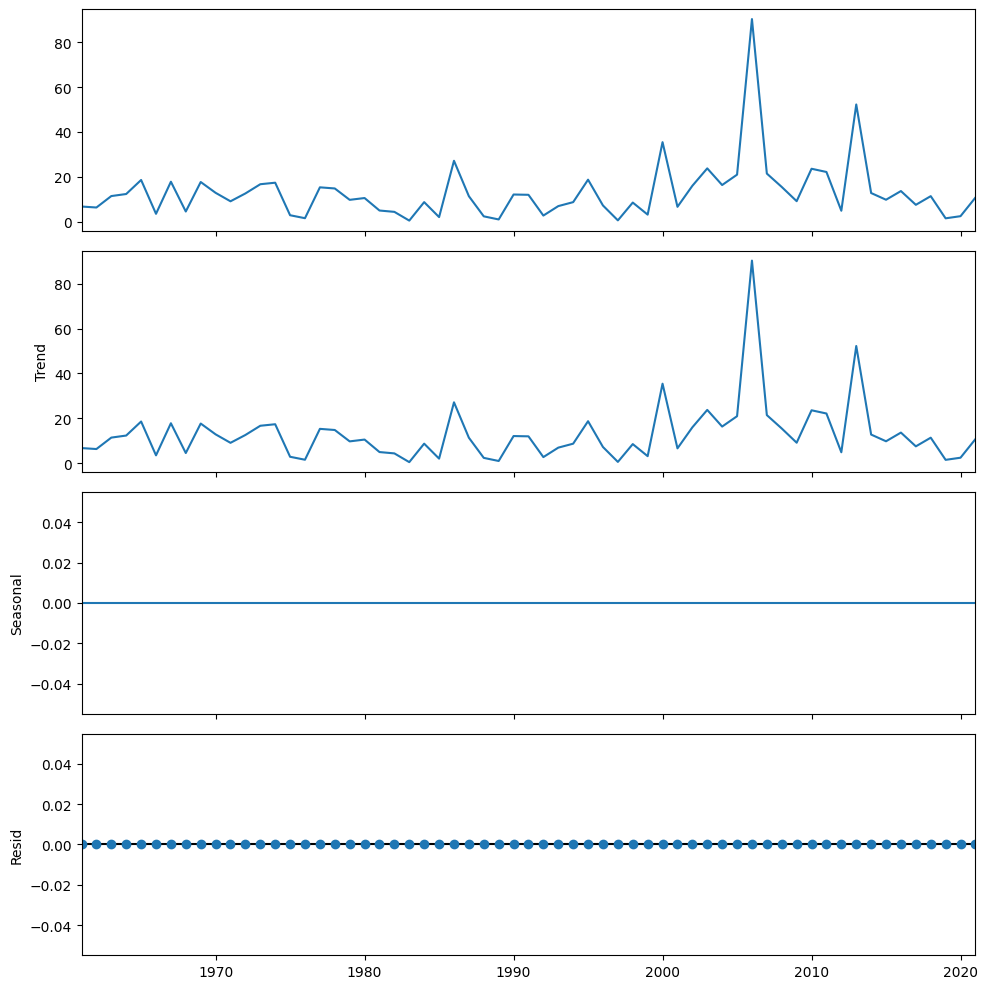

In [59]:
plt.rcParams['figure.figsize'] = 10, 10

# производим декомпозицию временного ряда
decomposition = seasonal.seasonal_decompose(gdp_vol)
decomposition.plot();

In [60]:
# прибираемся немного
del decomposition

gc.collect();

Декомпозиция временного ряда волатильности не отражает сезонности (цикличности), шума не проявляется, тренд отсутствует.

Оценим стационарность ряда (тест Дики-Фуллера):

In [61]:
# проверяем ряд на стационарность
get_adfuller_test(train_df, 2)

ADF Statistic: -6.725311059553779
p-value: 3.4014596148856493e-09
Critical Values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
При пороге '5%' единичных корней нет, ряд СТАЦИОНАРЕН


Построим коррелограммы волатильности:

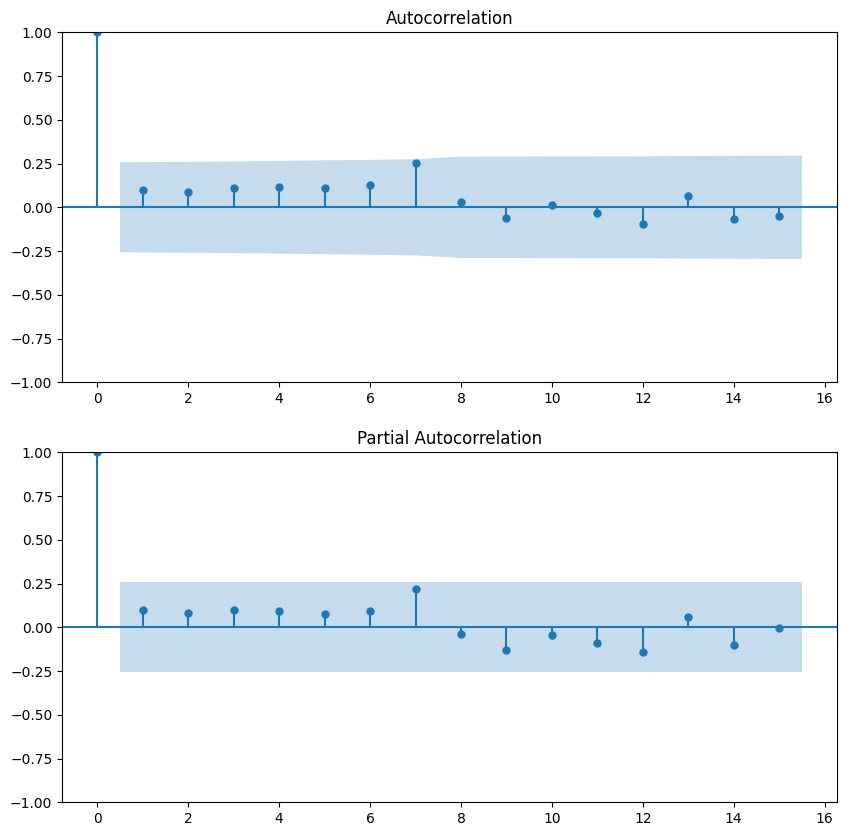

In [62]:
get_correlograms(train_df)

На графиках коррелограмм видно, практически, отсутствующую корреляцию со слабо выделяющимся 7 лагом, что говорит об отсутствии тренда, сезонной и шумовой составляющих, что подтверждает выводы по декомпозиции ранее.

На основании графиков автокорреляции и частичной автокорреляции выбираем параметры для модели:

* $p = 1$,
* $q = 1$.

Построим модель *GARCH(1, 1)*:

In [63]:
# задаём объект класса arch_model, обучаем модель
GARCH_1_1 = univariate.arch_model(gdp_vol, p=1, q=1, vol='GARCH')
GARCH_1_1_res = GARCH_1_1.fit(last_obs=test_df.index[0], update_freq=5)

# выводим результат
GARCH_1_1_res

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00251345130135
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Fri, Sep 13 2024   Df Residuals:                       57
Time:                        09:16:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.36

Вычислим предсказание для модели *GARCH*:

In [64]:
# формируем датасет исходных значений и предсказания модели GARCH
pred_GARCH_1_1 = test_df.copy()
pred_GARCH_1_1['pred_garch'] = GARCH_1_1_res.forecast().residual_variance.loc[
    test_df.index
]

# выводим результат
pred_GARCH_1_1

,GDP_vol,pred_garch
2019-01-01,1.542746,288.546011
2020-01-01,2.495937,292.216032
2021-01-01,10.780603,295.886053


Визуализируем прогноз модели *GARCH* и исходные данные:

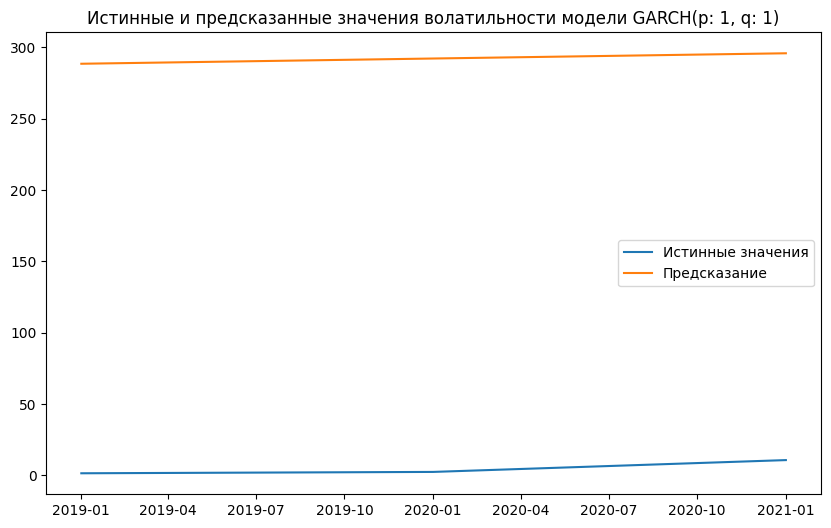

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(pred_GARCH_1_1[pred_GARCH_1_1.columns[0]], label='Истинные значения')
plt.plot(pred_GARCH_1_1[pred_GARCH_1_1.columns[1]], label='Предсказание')
plt.legend()
plt.title(f'Истинные и предсказанные значения волатильности модели {str(GARCH_1_1.volatility)}');

In [66]:
# прибираемся немного
# del GARCH_1_1, GARCH_1_1_res

gc.collect();

### 3.3. Модель LinearRegression (линейная регрессия)

In [68]:
# число фолдов кросс-валидации
CV_FOLDS = 5

# формируем тренировочные и тестовые выборки
X_train = pd.DataFrame(range(gdp_vol['GDP_vol'].shape[0]))[:train_df.shape[0]]
X_test = pd.DataFrame(range(gdp_vol['GDP_vol'].shape[0]))[train_df.shape[0]:]
y_train = train_df['GDP_vol']
y_test = test_df['GDP_vol']

# задаём объект класса LinearRegression
LR = linear_model.LinearRegression(n_jobs=-1)

# задаём объект класса GridSearchCV с кросс-валидацией TimeSeriesSplit, обучаем модель
GSCV_LR = model_selection.GridSearchCV(
    estimator=LR, 
    param_grid={'fit_intercept':[True, False]}, 
    scoring='r2', 
    n_jobs=-1, 
    cv=model_selection.TimeSeriesSplit(n_splits=CV_FOLDS, test_size=3), 
    verbose=1
)

# обучаем модель, ищем оптимальный гиперпараметр
GSCV_LR.fit(X_train, y_train)

# вычисляем предсказание GridSearchCV с LinearRegression на тестовой выборке
pred_GSCV_LR_test = GSCV_LR.predict(X_test)
pred_GSCV_LR_test

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=3),
             estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, scoring='r2',
             verbose=1)

array([19.81968247, 20.03529022, 20.25089797])

---

### 3.4. Визуализация предсказания LinearRegression

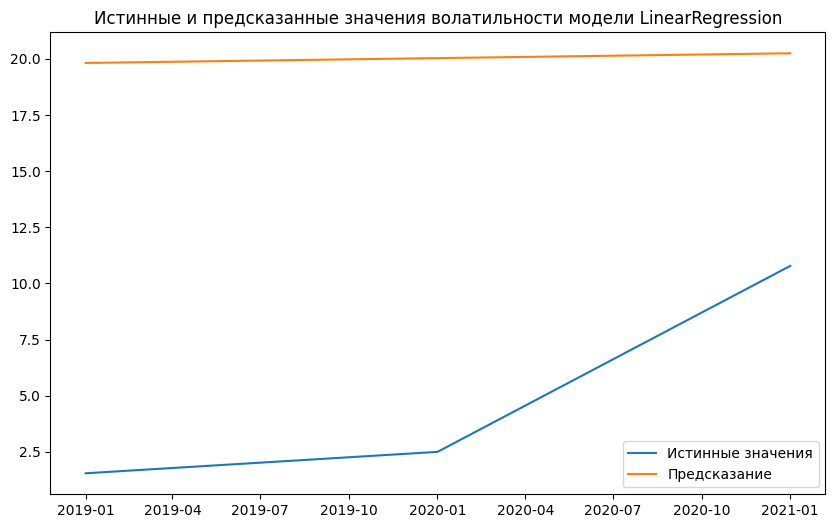

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Истинные значения')
plt.plot(pd.Series(pred_GSCV_LR_test, index=y_test.index), label='Предсказание')
plt.title(f'Истинные и предсказанные значения волатильности модели {LR.__class__.__name__}')
plt.legend();

---

### 3.5. Метрики, выводы

In [70]:
# метрики модели GARCH
get_metrics(
    pred_GARCH_1_1[pred_GARCH_1_1.columns[0]], 
    pred_GARCH_1_1[pred_GARCH_1_1.columns[1]], 
    train_df
)

MAPE: 10951.89 %
MSE: 8.25312e+06 $^2
RMSE: 2.87283e+02 $
R2: -4794.780
MASE: 25.490


In [71]:
# метрики модели LinearRegression с кросс-валидацией
get_metrics(
    y_test, 
    pred_GSCV_LR_test, 
    X_train
)

MAPE: 658.42 %
MSE: 2.43787e+04 $^2
RMSE: 1.56137e+01 $
R2: -13.166
MASE: 15.096


### **Выводы:**

Метрики для *GARCH(1, 1)* и  *LinearRegression* показывают, что простая модель линейной регрессии с кросс-валидацией показала значительно лучший результат, неидеальный, но всё же, гораздо, лучше.

В таблице сведены метрики по каждой модели:

<center>

| Метрика | <div style="width:200px">GARCH(1, 1)</div> | <div style="width:200px">LinearRegression()<br>с кросс-валидацией</div> |
| :---: | :---: | :---: |
| $AIC$ | 461.196 | - |
| $MAPE, \%$ | <font color='Tomato'>**10951.89**</font> | <font color='LightSeaGreen'>**658.42**</font> |
| $MSE, \$^2$ | <font color='Tomato'>**8.25312e+06**</font> | <font color='LightSeaGreen'>**2.43787e+04**</font> |
| $RMSE, \$$ | <font color='Tomato'>**2.87283e+02**</font> | <font color='LightSeaGreen'>**1.56137e+01**</font> |
| $R_2$ | <font color='Tomato'>**-4794.780**</font> | <font color='LightSeaGreen'>**-13.166**</font> |
| $MASE$ | <font color='Tomato'>**25.490**</font> | <font color='LightSeaGreen'>**15.096**</font> |

</center>

<br>

---

### 3.6. Заключение

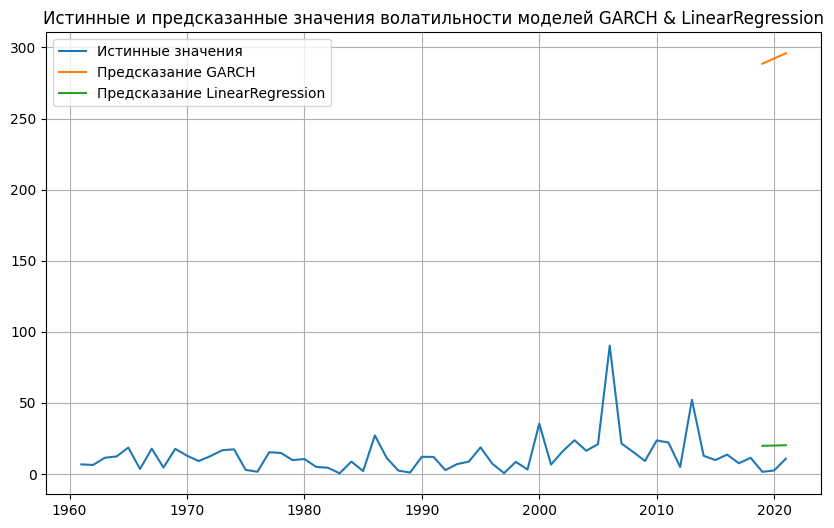

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(gdp_vol, label='Истинные значения')
plt.plot(pred_GARCH_1_1[pred_GARCH_1_1.columns[1]], label='Предсказание GARCH ')
plt.plot(pd.Series(pred_GSCV_LR_test, index=y_test.index), label='Предсказание LinearRegression')
plt.title('Истинные и предсказанные значения волатильности моделей GARCH & LinearRegression')
plt.legend()
plt.grid();

### **Выводы:**

* Проанализировав волатильность временного ряда и построив *GARCH* модель получен неудовлетворительный результат, модель совсем не уловила дисперсию, случаи возрастания и убывания дисперсии отсутствовали в обучающей выборке. 

* Ранее выявлено, что ряд являетcя **гомоскедастичным**, т.е. обладает слабой дисперсией на всём своём протяжении, за исключением нескольких значительных выбросов. На имеющихся данных модель *GARCH* показала себя очень слабо, даже, в сравнении линейной регрессии, где метрики оказались, значительно, лучше, на порядки.

* Модель GARCH показывает значительное расхождение с фактическими значениями волатильности. Из автокорреляционных графиков следует, что автокорреляция волатильности в представленном временном ряде отсутствует, т.к. предыдущие значения ряда не влияют / слабо влияют на последующие. Возможно, зависимость могла бы проявиться, если бы ряд был бы более объёмный по количеству наблюдений.

* Окончательно, на основании метрик, можно сделать вывод, что модель *GARCH* <font color='Tomato'>**не применима под эти данные.**</font>

---